### Setup

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tweepy, gensim, nltk, yaml, os, sys
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sys.path.append(os.path.abspath("../../../src/"))
from helper.utils import *
from helper.convmanager import *
from helper.twitter_utils import *

credentials = Credentials('../../../res/credentials.yml')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/piemontec/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Getting the API instance

In [2]:
auth = tweepy.OAuthHandler(
    credentials.twitter['CONSUMER_KEY'],
    credentials.twitter['CONSUMER_SECRET'])
auth.set_access_token(
    credentials.twitter['ACCESS_TOKEN'],
    credentials.twitter['ACCESS_TOKEN_SECRET'])

api = tweepy.API(auth)

### Get Tweets and Conversations

In [3]:
%%time
search_options = {
    'q':          'christmas',  # query
    'lang':       'en',         # language
    'tweet_mode': 'extended'    # get full tweet text
}
statuses = tweepy.Cursor(api.search, **search_options).items(1000)               #
tweets   = [[convert(status)] for status in statuses if is_response(status)]     #
convs    = [extend(api, tweet) for tweet in tweets]                              #
merged_convs = merge_conversations(convs, has_common=has_common_tweet)           #

print('RESPONSE TWEETS:         %s' % len(tweets))
print('MAX CONVERSATION LENGTH: %s' % max([len(i) for i in convs]), '\n')

RESPONSE TWEETS:         175
MAX CONVERSATION LENGTH: 47 

CPU times: user 9.55 s, sys: 757 ms, total: 10.3 s
Wall time: 2min 28s


### Build the Graph

In [4]:
%%time

plt.rcParams["figure.figsize"] = [15, 7]
plt.style.use('ggplot')

ConvGraph = nx.DiGraph()

# model = gensim.models.KeyedVectors.load_word2vec_format('../models/pretrained/GoogleNews-vectors-negative300.bin.gz', binary=True)
best_conv = [max(merged_convs, key=len)]

for conv in best_conv:
    for i, tweet in enumerate(conv):
        if tweet.parent is not None:
            answered_tweet = conv[i+1]
            similarity = tweet.get_similarity(answered_tweet)
            ConvGraph.add_edge(tweet.id, tweet.parent, weight=similarity)

CPU times: user 526 µs, sys: 1e+03 ns, total: 527 µs
Wall time: 531 µs


#### Draw the Graph

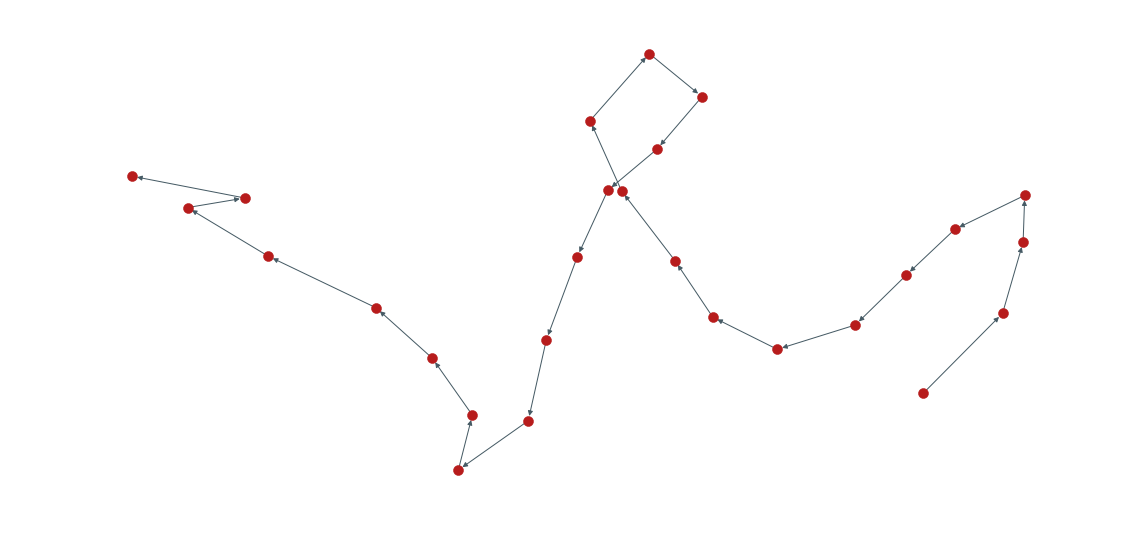

In [5]:
pos = nx.spring_layout(ConvGraph)
edge_labels = nx.get_edge_attributes(ConvGraph, 'weight')

draw_options = {
    'with_labels': False,
    'node_shape' : 'o',
    'node_color' : '#B71C1C',
    'edge_color' : '#455A64',
    'node_size'  : 100,
    'width': 1
}

nx.draw(ConvGraph, pos, **draw_options)
# nx.draw_networkx_edge_labels(ConvGraph, pos, edge_labels=edge_labels, font_color='#006064');